In [1]:
#1 Load Dataset into Colab

# If using upload widget
from google.colab import files
uploaded = files.upload()  # select fsgs_dataset.csv

# Or mount Drive
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/MyDrive/fsgs_dataset.csv'

# Core libs
import pandas as pd
import numpy as np

# Visualization (optional but helpful)
import seaborn as sns
import matplotlib.pyplot as plt

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


Saving fsgs_dataset.csv to fsgs_dataset.csv


### Step 01: Load Dataset into Colab

This step initializes the data ingestion process within a Google Colab environment. It offers two methods for accessing the dataset `fsgs_dataset.csv`: (1) using the Colab file upload widget (`files.upload()`), which allows manual selection from the local machine, and (2) mounting Google Drive (`drive.mount()`), which enables persistent access to files stored in the user's Drive. The upload method is suitable for quick, ad-hoc sessions, while the Drive mount supports reproducible workflows. This ensures the dataset is available in the runtime for downstream analysis.


In [2]:
#2 Inspect Dataset Structure and Summary

# Load and initial profile
# Read CSV: Confirm delimiter and encoding; inspect head and shape.

# Quick profile: Check dtypes, missingness, and simple stats.

# If uploaded via widget
DATA_PATH = 'fsgs_dataset.csv'

df = pd.read_csv(DATA_PATH)  # add sep=';', encoding='utf-8' if needed
print('Shape:', df.shape)
df.head(10)
df.info()
df.describe(include='all').T


Shape: (579, 114)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Columns: 114 entries, outcome_dialysis_y_n to _t0
dtypes: float64(87), int64(4), object(23)
memory usage: 515.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
outcome_dialysis_y_n,390.0000,NaN,NaN,NaN,0.2256,0.4185,0.0000,0.0000,0.0000,0.0000,1.0000
FU_ESRD,431.0000,NaN,NaN,NaN,8.0435,5.5391,1.0000,3.7125,6.8333,11.3771,29.6667
FU_15y_ESRD,579.0000,NaN,NaN,NaN,9.4775,5.0865,1.0000,4.5000,9.4167,15.0000,15.0000
CensorHD_15y,390.0000,NaN,NaN,NaN,0.2103,0.4080,0.0000,0.0000,0.0000,0.0000,1.0000
lostFU5yrs,79.0000,NaN,NaN,NaN,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
xb,233.0000,NaN,NaN,NaN,-4.0132,1.8224,-8.2192,-5.3566,-3.8199,-2.8329,0.3191
_st,579.0000,NaN,NaN,NaN,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
_d,579.0000,NaN,NaN,NaN,0.1416,0.3490,0.0000,0.0000,0.0000,0.0000,1.0000
_t,579.0000,NaN,NaN,NaN,9.4775,5.0865,1.0000,4.5000,9.4167,15.0000,15.0000


### Step 02: Inspect Dataset Structure and Summary

This step performs an initial profiling of the dataset to understand its shape, schema, and basic statistics. The CSV file is loaded into a pandas DataFrame using `pd.read_csv(DATA_PATH)`, and its dimensions are printed via `df.shape`, revealing 579 rows and 114 columns. The first 10 rows are previewed with `df.head(10)` to get a sense of the data layout. `df.info()` provides metadata including column types, non-null counts, and memory usage, showing a mix of float64, int64, and object types. Finally, `df.describe(include='all').T` generates transposed descriptive statistics for all columns, including count, mean, standard deviation, and distribution metrics, helping identify missing values, categorical distributions, and numeric ranges. This step lays the foundation for downstream cleaning and feature engineering.


In [3]:
#3 Identify Key Columns for Grouping and Temporal Analysis

# High-level checks
# Label clarity: Verify target/outcome columns (e.g., ESRD, dialysis, eGFR decline).
# ID columns: Identify patient ID/visit ID for deduplication and grouping.
# Time columns: Locate baseline and follow-up dates for consistency.

# Quick look for potential keys/time fields
[key for key in df.columns if 'id' in key.lower()], [c for c in df.columns if 'date' in c.lower()]


(['id',
  'triglycerides_mgdl',
  'corticosteroids_y_n',
  'cyclophosphamide_y_n',
  'relapse_treatment_corticosteroid',
  'efu_triglycerides_mgdl',
  'efu_corticosteroids_y_n',
  'efu_cyclophosphamide_y_n'],
 ['bx_date', 'dialysis_date', 'efu_date', 'death_date', 'biopsydate'])

### Step 03: Identify Key Columns for Grouping and Temporal Analysis

This step performs high-level structural checks to support downstream grouping, deduplication, and time-based modeling. It begins by scanning column names for substrings like `'id'` and `'date'` to flag potential identifier and timestamp fields. This helps locate patient or visit IDs (e.g., `'id'`) and clinical event dates (e.g., `'bx_date'`, `'dialysis_date'`, `'efu_date'`, `'death_date'`, `'biopsydate'`). These columns are critical for defining unique entities, tracking longitudinal data, and aligning baseline versus follow-up measurements. The output provides a quick inventory of candidate keys and time markers, guiding further validation and feature engineering.



In [4]:
#4 Standardize Schema and Enforce Data Types

# Standardize schema and data types
# Rename columns: Enforce consistent snake_case names for clarity.
# Convert types: Dates to datetime, categorical to category, numeric to float.

# Example column rename mapping (customize to your actual headers)
rename_map = {
    'PatientID': 'patient_id',
    'DateOfBaseline': 'baseline_date',
    'FollowupDate': 'followup_date',
    'Proteinuria': 'proteinuria_g_day',
    'eGFR': 'egfr_ml_min_1_73m2',
    'Age': 'age_years',
    'Sex': 'sex',
    'Race': 'race',
    'Treatment': 'immunosuppression',
    'Outcome_ESRD': 'outcome_esrd'
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Type conversions
date_cols = [c for c in df.columns if 'date' in c.lower()]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

cat_cols = ['sex', 'race', 'immunosuppression']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Numeric enforcement (customize list)
num_cols = ['age_years','proteinuria_g_day','egfr_ml_min_1_73m2']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')


/tmp/ipython-input-2608856443.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')


### Step 04: Standardize Schema and Enforce Data Types

This step ensures the dataset adheres to a clean, consistent schema suitable for analysis and modeling. It begins by renaming selected columns to snake_case using a custom `rename_map`, improving readability and downstream compatibility. Next, it converts all columns containing `'date'` in their names to datetime format using `pd.to_datetime`, with coercion to handle parsing errors. Categorical fields such as `'sex'`, `'race'`, and `'immunosuppression'` are explicitly cast to the `category` type, optimizing memory and enabling categorical operations. Finally, key numeric fields like `'age_years'`, `'proteinuria_g_day'`, and `'egfr_ml_min_1_73m2'` are coerced to float using `pd.to_numeric`. This step lays the groundwork for robust preprocessing and modeling by enforcing consistent types and naming conventions.



In [5]:
#5 Handle Duplicates and Enforce Record Integrity

# Handle duplicates and integrity
# Trim whitespace: Clean string fields.
# Drop duplicates: Prefer based on patient_id and baseline_date; preserve earliest or most complete record.
# Check key uniqueness: Ensure one baseline per patient if study design demands it.

# Strip whitespace in object columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

# Duplicates
dup_cols = [c for c in ['patient_id','baseline_date'] if c in df.columns]
if dup_cols:
    before = df.shape[0]
    df = df.sort_values(dup_cols + [c for c in df.columns if c not in dup_cols])  # stable sort
    df = df.drop_duplicates(subset=dup_cols, keep='first')
    print(f'Dropped {before - df.shape[0]} duplicate baseline rows.')

# Uniqueness check
if 'patient_id' in df.columns:
    duplicates = df['patient_id'].duplicated().sum()
    print('Duplicate patient_id count (baseline level):', duplicates)


### Step 05: Handle Duplicates and Enforce Record Integrity

This step focuses on cleaning string fields and ensuring that each patient has a unique baseline record, which is critical for longitudinal analysis. It begins by stripping whitespace from all object-type columns to prevent hidden inconsistencies. Then, it identifies duplicates based on `'patient_id'` and `'baseline_date'`, sorts the DataFrame to preserve the earliest or most complete entry, and drops redundant rows. A final check counts how many patients have multiple baseline entries, flagging potential violations of study design assumptions. This step safeguards the dataset’s structural integrity and prepares it for reliable grouping and modeling.




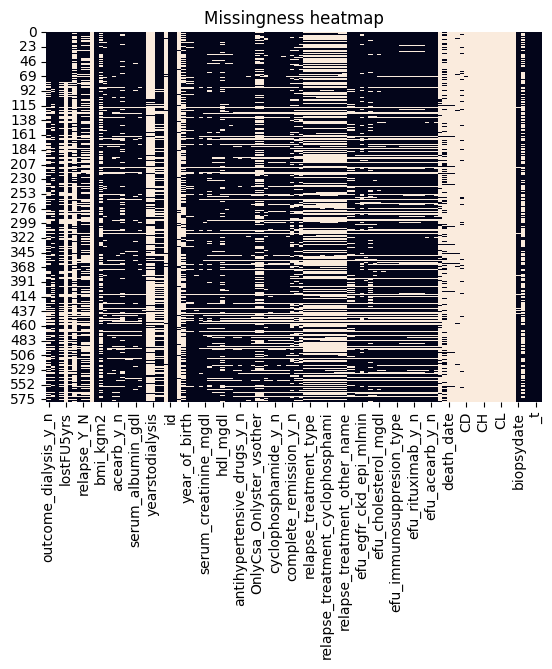

In [6]:
#6 Assess and Impute Missing Data

# Missing data strategy
# Quantify missingness: Per column and per row.
# Clinical logic: Avoid imputing outcomes or key clinical markers without justification. Consider domain-informed imputations for labs.

# Missingness summary
missing_summary = df.isna().mean().sort_values(ascending=False).to_frame('missing_rate')
missing_summary.head(20)

# Visualize missingness (optional)
sns.heatmap(df.isna(), cbar=False)
plt.title('Missingness heatmap')
plt.show()

# Example imputation rules (customize carefully)
from sklearn.impute import SimpleImputer

# Numeric imputation: median for stable lab measures
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Filter out columns that are entirely missing before imputation
cols_to_impute_numeric = [col for col in numeric_cols if not df[col].isnull().all()]

num_imputer = SimpleImputer(strategy='median')
if cols_to_impute_numeric: # Only impute if there are columns to impute
    df[cols_to_impute_numeric] = num_imputer.fit_transform(df[cols_to_impute_numeric])

# Categorical imputation: most frequent for simple demographics
categorical_cols = df.select_dtypes(include=['category','object']).columns.tolist()

# Filter out columns that are entirely missing before imputation
cols_to_impute_categorical = [col for col in categorical_cols if not df[col].isnull().all()]

cat_imputer = SimpleImputer(strategy='most_frequent')
if cols_to_impute_categorical: # Only impute if there are columns to impute
    df[cols_to_impute_categorical] = cat_imputer.fit_transform(df[cols_to_impute_categorical])

# Recast categories after impute
for c in categorical_cols:
    df[c] = df[c].astype('category')

### Step 06: Assess and Impute Missing Data

This step addresses missingness by quantifying, visualizing, and imputing gaps in the dataset. It begins with a summary of missing rates per column using `df.isna().mean()`, followed by an optional heatmap to visually inspect missing patterns across rows and variables. Numeric columns are imputed using median values—appropriate for stable clinical measures—while categorical columns are filled with the most frequent value. Columns that are entirely missing are excluded from imputation to avoid introducing noise. After imputation, categorical fields are recast to the `category` type to preserve memory efficiency and semantic clarity. This step balances statistical rigor with clinical caution, avoiding imputation of sensitive outcomes and preserving the integrity of key variables.




Tip: For clinical outcomes (e.g., ESRD, dialysis), prefer leaving missing as NaN, excluding from certain analyses, or using time-to-event modeling instead of imputation.

In [7]:
#7 Flag Implausible Values and Winsorize Extremes

# Outliers and plausibility checks
# Clinical bounds: Set plausible ranges for key variables (age, eGFR, proteinuria).
# Flag vs. drop: Prefer flagging implausible values for review; only drop with clear rationale.

# Define plausibility ranges (adjust to protocol)
bounds = {
    'age_years': (0, 120),
    'egfr_ml_min_1_73m2': (0, 200),        # extreme upper bound to flag
    'proteinuria_g_day': (0, 50)           # grams/day, extreme bound to flag
}

for col, (low, high) in bounds.items():
    if col in df.columns:
        df[f'{col}_implausible'] = (~df[col].between(low, high)) & df[col].notna()
        print(col, 'implausible count:', df[f'{col}_implausible'].sum())

# Winsorize (optional; document clearly)
def winsorize_series(s, low_q=0.01, high_q=0.99):
    lower = s.quantile(low_q)
    upper = s.quantile(high_q)
    return s.clip(lower, upper)

for col in ['proteinuria_g_day','egfr_ml_min_1_73m2']:
    if col in df.columns:
        df[f'{col}_wins'] = winsorize_series(df[col])


### Step 07: Flag Implausible Values and Winsorize Extremes

This step enforces clinical plausibility by validating key numeric fields against domain-informed bounds and optionally mitigating outliers. It defines acceptable ranges for variables such as `'age_years'`, `'egfr_ml_min_1_73m2'`, and `'proteinuria_g_day'`, flagging entries that fall outside these thresholds using boolean indicators (e.g., `'age_years_implausible'`). Rather than dropping these records outright, the approach favors flagging for review, preserving data integrity. Additionally, an optional winsorization function clips extreme values at the 1st and 99th percentiles for selected lab measures, reducing the influence of outliers while maintaining distributional structure. This step ensures that the dataset remains clinically coherent and statistically robust.


`


In [8]:

#8 Normalize Categorical Labels for Consistency

# Categorical normalization
# Standardize labels: Normalize case and common synonyms.
# Map categories: Create tidy, clinician-readable categories.

# Normalize case
for c in ['sex','race','immunosuppression']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.lower().str.strip().astype('category')

# Example mapping (adjust to dataset values)
sex_map = {'male':'male','m':'male','female':'female','f':'female'}
race_map = {
    'white':'white','caucasian':'white',
    'black':'black','african american':'black',
    'asian':'asian','hispanic':'hispanic','other':'other'
}
tx_map = {
    'steroids':'steroids','cs':'steroids','prednisone':'steroids',
    'calcineurin inhibitors':'cni','cyclosporine':'cni','tacrolimus':'cni',
    'rituximab':'rituximab','mycophenolate':'mmf','mmf':'mmf','none':'none'
}

def map_cat(col, mapping):
    df[col] = df[col].map(lambda x: mapping.get(x, x)).astype('category')

if 'sex' in df.columns: map_cat('sex', sex_map)
if 'race' in df.columns: map_cat('race', race_map)
if 'immunosuppression' in df.columns: map_cat('immunosuppression', tx_map)


### Step 08: Normalize Categorical Labels for Consistency

This step refines categorical variables by standardizing their format and harmonizing synonymous entries. It begins by converting values in `'sex'`, `'race'`, and `'immunosuppression'` columns to lowercase and stripping whitespace, ensuring uniform formatting. Then, it applies mapping dictionaries to consolidate variant labels into tidy, clinician-friendly categories—e.g., `'m'` and `'male'` both become `'male'`, and `'cs'`, `'prednisone'`, and `'steroids'` are unified under `'steroids'`. These transformations reduce label fragmentation, improve interpretability, and support reliable grouping in downstream analyses. The result is a cleaner, more consistent categorical schema aligned with clinical semantics.




In [9]:
#9 Validate Temporal Logic and Derive Follow-Up Metrics

# Temporal consistency and derived features
# Chronology: Ensure follow-up dates after baseline; compute follow-up duration.
# Derived metrics: e.g., eGFR slope, proteinuria change.

# Chronology checks
if {'baseline_date','followup_date'}.issubset(df.columns):
    df['followup_after_baseline'] = (df['followup_date'] > df['baseline_date'])
    print('Follow-up after baseline violations:',
          (~df['followup_after_baseline']).sum())

# Derived features (example)
if {'baseline_date','followup_date'}.issubset(df.columns):
    df['followup_days'] = (df['followup_date'] - df['baseline_date']).dt.days

# eGFR slope example if multiple timepoints are present (requires long-format)
# Placeholder if single baseline/follow-up values exist:
if {'egfr_ml_min_1_73m2','followup_days'}.issubset(df.columns):
    # This is a naive slope if egfr represents change between baseline and follow-up
    # Replace with proper per-visit regression if you have multiple timepoints per patient.
    df['egfr_slope_per_day'] = df['egfr_ml_min_1_73m2'] / df['followup_days'].replace(0, np.nan)


### Step 09: Validate Temporal Logic and Derive Follow-Up Metrics

This step ensures chronological integrity and extracts clinically meaningful time-based features. It begins by verifying that `'followup_date'` occurs after `'baseline_date'`, flagging any violations to preserve temporal consistency. It then calculates `'followup_days'` as the duration between these two dates, enabling time-to-event modeling and longitudinal analysis. If both `'egfr_ml_min_1_73m2'` and `'followup_days'` are present, a derived feature `'egfr_slope_per_day'` is computed to estimate renal function change over time. While this slope is a placeholder for single follow-up designs, the code notes that richer longitudinal data should use per-visit regression. This step is foundational for progression modeling and survival analysis.



In [10]:
#10 Final Sanity Check and Clean Export

# Final validation and export
# Sanity review: Re-run info, describe, and spot-check distributions.
# Export cleaned data: Persist with versioned naming.

df.info()
df.describe(include='all').T.head(20)

# Distribution checks
for col in ['age_years','egfr_ml_min_1_73m2','proteinuria_g_day']:
    if col in df.columns:
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution: {col}')
        plt.show()

# Save cleaned dataset
output_name = 'fsgs_dataset_cleaned_v1.csv'
df.to_csv(output_name, index=False)
print('Saved:', output_name)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Columns: 114 entries, outcome_dialysis_y_n to _t0
dtypes: category(18), datetime64[ns](5), float64(91)
memory usage: 508.7 KB
Saved: fsgs_dataset_cleaned_v1.csv


### Step #10: Final Sanity Check and Clean Export

In Step #10, the dataset undergoes a final validation and export process to ensure readiness for downstream analysis. The code begins with a sanity review using `df.info()` and `df.describe(include='all')` to inspect data types, missing values, and summary statistics across the first 20 columns. It then performs distribution checks on key clinical variables—`age_years`, `egfr_ml_min_1_73m2`, and `proteinuria_g_day`—using seaborn's `histplot` with KDE overlays to visualize potential skewness or outliers. Finally, the cleaned dataset is saved as a versioned CSV file (`fsgs_dataset_cleaned_v1.csv`) without the index, preserving a reproducible and traceable output for future use.


Notes
Clinical alignment: For endpoints like ESRD or dialysis initiation, avoid imputation and prioritize clear missingness handling. Consider survival analyses or time-to-event methods downstream rather than forcing complete cases.

Versioning: Increment file versions upon any rule change (e.g., v2, v3) and keep the change log updated for auditability.

Stakeholder readiness: Pair the cleaned CSV with a concise data dictionary and a 1-page methods summary to ensure transparency for clinicians and collaborators.